In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('../Dataset/mergedData.csv')

In [3]:
df.head()

,text,label
0,nigerian soldier battle boko haram kill r...,1
1,noah green capitol attacker supporter natio...,1
2,year ago tweet outed raid osama bin laden,1
3,terrorist attack austria,1
4,soldier receives medal honor helping save c...,1


In [4]:
text = df['text']
label = df['label']

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

In [6]:
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1

In [7]:
sequence = tokenizer.texts_to_sequences(text)
padded_sequence = pad_sequences(sequence,padding='post')

In [8]:
x_train, x_test, y_train, y_test = train_test_split(padded_sequence,label,test_size=0.3,shuffle=True,random_state = 42)

In [11]:
pip install urllib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement urllib (from versions: none)
ERROR: No matching distribution found for urllib


In [12]:
import urllib.request

In [13]:
url = 'https://www.kaggle.com/datasets/danielwillgeorge/glove6b100dtxt'
filename = 'glove.6B.100d.txt'
urllib.request.urlretrieve(url, filename)

('glove.6B.100d.txt', <http.client.HTTPMessage at 0x7f5e8e4946d0>)

In [16]:
embeddings_index = {};
with open(filename) as f:
    for line in f:
        values = line.split()
        if len(values) >= 2:
            word = values[0]
            coefs = []
            for val in values[1:]:
                try:
                    coefs.append(float(val))
                except ValueError:
                    pass
            if len(coefs) == 100:
                embeddings_index[word] = coefs

embeddings_matrix = np.zeros((vocab_size,100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [17]:
model = Sequential()

model.add(Embedding(vocab_size,100,weights=[embeddings_matrix],trainable=False))
model.add(Bidirectional(LSTM(32,return_sequences=True)))
model.add(Bidirectional(LSTM(32)))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         993900    
                                                                 
 bidirectional (Bidirectiona  (None, None, 64)         34048     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,054,893
Trainable params: 60,993
Non-tra

In [19]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [20]:
history = model.fit(x_train,y_train,batch_size=32,epochs=10,validation_data=(x_test,y_test))

Epoch 1/10
118/118 [==============================] - 62s 426ms/step - loss: 0.6791 - accuracy: 0.7438 - val_loss: 0.6657 - val_accuracy: 0.7515
Epoch 2/10
118/118 [==============================] - 49s 413ms/step - loss: 0.6553 - accuracy: 0.7475 - val_loss: 0.6440 - val_accuracy: 0.7515
Epoch 3/10
118/118 [==============================] - 49s 412ms/step - loss: 0.6360 - accuracy: 0.7475 - val_loss: 0.6261 - val_accuracy: 0.7515
Epoch 4/10
118/118 [==============================] - 48s 410ms/step - loss: 0.6203 - accuracy: 0.7475 - val_loss: 0.6117 - val_accuracy: 0.7515
Epoch 5/10
118/118 [==============================] - 49s 412ms/step - loss: 0.6076 - accuracy: 0.7475 - val_loss: 0.6002 - val_accuracy: 0.7515
Epoch 6/10
118/118 [==============================] - 49s 414ms/step - loss: 0.5976 - accuracy: 0.7475 - val_loss: 0.5910 - val_accuracy: 0.7515
Epoch 7/10
118/118 [==============================] - 49s 413ms/step - loss: 0.5896 - accuracy: 0.7475 - val_loss: 0.5836 - val_ac

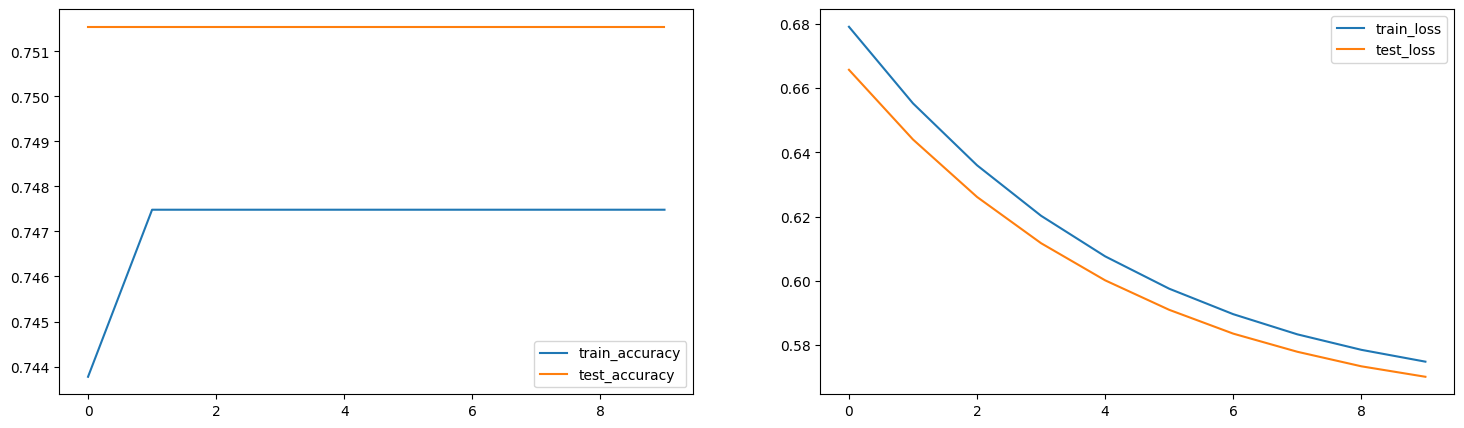

In [21]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2,figsize=(18,5))
ax1.plot(history.history['accuracy'],label='train_accuracy')
ax1.plot(history.history['val_accuracy'],label='test_accuracy')
ax1.legend()
ax2.plot(history.history['loss'],label='train_loss')
ax2.plot(history.history['val_loss'],label='test_loss')
ax2.legend()
plt.show()


In [22]:
model.evaluate(x_test,y_test)

51/51 [==============================] - 8s 159ms/step - loss: 0.5701 - accuracy: 0.7515


[0.5701427459716797, 0.7515451312065125]

In [23]:
model.save('./lstm.h5')

In [24]:
pred = model.predict(x_test)

51/51 [==============================] - 9s 143ms/step


In [25]:
pred = pred>0.5

In [26]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.75      0.86      1618

    accuracy                           0.75      1618
   macro avg       0.50      0.38      0.43      1618
weighted avg       1.00      0.75      0.86      1618



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
